In [8]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import mediapipe as mp
from tqdm import tqdm
import numpy as np

In [9]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


In [10]:
class PairedImageDataset(Dataset):
    def __init__(self, root_dir, phase, grayscale_transform=None, color_transform=None):
        self.grayscale_dir = os.path.join(root_dir, phase, 'grayscale')
        self.color_dir = os.path.join(root_dir, phase, 'color')
        self.grayscale_transform = grayscale_transform
        self.color_transform = color_transform
        self.image_names = [f for f in os.listdir(self.grayscale_dir) if os.path.isfile(os.path.join(self.grayscale_dir, f))]
        
        self.labels = []
        self.valid_image_names = []
        for filename in self.image_names:
            if filename[0].isupper() and filename[1] == '_': 
                parts = filename.split('_')
                try:
                    label = parts[0] # extract label
                    self.labels.append(label)
                    self.valid_image_names.append(filename)
                except ValueError:
                    continue
        
        self.image_names = self.valid_image_names

        unique_labels = sorted(set(self.labels))
        self.label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
        self.labels = [self.label_mapping[label] for label in self.labels]

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        grayscale_path = os.path.join(self.grayscale_dir, self.image_names[idx])
        color_path = os.path.join(self.color_dir, self.image_names[idx])

        grayscale_image = Image.open(grayscale_path).convert('L')
        color_image = Image.open(color_path).convert('RGB')

        if self.grayscale_transform:
            grayscale_image = self.grayscale_transform(grayscale_image)
        if self.color_transform:
            color_image = self.color_transform(color_image)

        label = self.labels[idx]
        return grayscale_image, color_image, label

grayscale_transform = transforms.Compose([
    transforms.Resize((50, 50)),
    transforms.ToTensor()
])

color_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [11]:
root_dir = 'newdata_dual_data'
train_dataset = PairedImageDataset(root_dir, 'train', grayscale_transform, color_transform)
val_dataset = PairedImageDataset(root_dir, 'val', grayscale_transform, color_transform)
test_dataset = PairedImageDataset(root_dir, 'test', grayscale_transform, color_transform)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [12]:
class DualInputCNN(nn.Module):
    def __init__(self, num_classes=24):
        super(DualInputCNN, self).__init__()

        # Grayscale CNN
        self.grayscale_cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.BatchNorm2d(64),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(128, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(512, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2)
        )

        # Landmark CNN
        self.landmark_cnn = nn.Sequential(
            nn.Conv2d(1, 50, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(50),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(50, 25, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(25),
            nn.Dropout2d(0.2)
        )

        # Fully connected layers
        self.fc1 = nn.Linear(32*3*3 + 25*10*1, 512)
        self.fc_dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(512, num_classes)  # Assuming 10 classes

    def forward(self, grayscale, landmarks):
        # Grayscale pathway
        x1 = self.grayscale_cnn(grayscale)
        x1 = x1.view(-1, 32*3*3)

        # Color pathway
        x2 = self.landmark_cnn(landmarks)
        x2 = x2.view(-1, 25*10*1)

        # Concatenate and classify
        x = torch.cat((x1, x2), dim=1)
        x = self.fc_dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [13]:
def process_with_mediapipe(color_images):
    batch_landmarks = []
    for color_image in color_images:
        color_image_np = color_image.permute(1, 2, 0).cpu().numpy() 
        color_image_np = (color_image_np * 255).astype(np.uint8) 
        color_image_np = np.ascontiguousarray(color_image_np) 
        results = mp_hands.process(color_image_np)
        landmarks = []
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                for lm in hand_landmarks.landmark:
                    landmarks.append([lm.x, lm.y, lm.z])
        # If no landmarks found or fewer than 21, fill with zeros
        while len(landmarks) < 21:
            landmarks.append([0.0, 0.0, 0.0])
        batch_landmarks.append(landmarks)
    landmarks_tensor = torch.tensor(batch_landmarks, dtype=torch.float32)
    return landmarks_tensor.view(len(color_images), 1, 21, 3).to(device)  # Move back to device


In [14]:
mp_hands = mp.solutions.hands.Hands(static_image_mode=True, max_num_hands=1)

model = DualInputCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    train_progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs} Training')

    for data in train_progress_bar:
        grayscale_images, color_images, labels = data

        grayscale_images = grayscale_images.to(device)
        color_images = color_images.to(device)
        labels = labels.to(device)

        landmarks = process_with_mediapipe(color_images)

        optimizer.zero_grad()
        outputs = model(grayscale_images, landmarks)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

        train_progress_bar.set_postfix({
            'loss': running_loss / (train_progress_bar.n + 1),
            'accuracy': correct_predictions / total_predictions
        })

    model.eval()
    val_loss = 0.0
    val_correct_predictions = 0
    val_total_predictions = 0
    val_progress_bar = tqdm(val_loader, desc=f'Epoch {epoch + 1}/{num_epochs} Validation')

    with torch.no_grad():
        for data in val_progress_bar:
            grayscale_images, color_images, labels = data

            grayscale_images = grayscale_images.to(device)
            color_images = color_images.to(device)
            labels = labels.to(device)

            landmarks = process_with_mediapipe(color_images)

            outputs = model(grayscale_images, landmarks)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_correct_predictions += (predicted == labels).sum().item()
            val_total_predictions += labels.size(0)

            val_progress_bar.set_postfix({
                'val_loss': val_loss / (val_progress_bar.n + 1),
                'val_accuracy': val_correct_predictions / val_total_predictions
            })

    print(f'Epoch {epoch + 1}, Training loss: {running_loss / len(train_loader):.3f}, Training accuracy: {correct_predictions / total_predictions:.3f}, Validation loss: {val_loss / len(val_loader):.3f}, Validation accuracy: {val_correct_predictions / val_total_predictions:.3f}')

print('Finished Training')



I0000 00:00:1717530168.825557 4036956 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 83.1), renderer: Apple M2 Pro
W0000 00:00:1717530168.832557 4056273 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1717530168.836548 4056273 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Epoch 1/10 Training: 100%|█| 4183/4183 [1:11:35<00:00,  1.03s/it, loss=0.876, ac
Epoch 1/10 Validation: 100%|█| 897/897 [11:30<00:00,  1.30it/s, val_loss=0.421, 


Epoch 1, Training loss: 0.876, Training accuracy: 0.732, Validation loss: 0.421, Validation accuracy: 0.869


Epoch 2/10 Training: 100%|█| 4183/4183 [56:37<00:00,  1.23it/s, loss=0.457, accu
Epoch 2/10 Validation: 100%|█| 897/897 [11:30<00:00,  1.30it/s, val_loss=0.275, 


Epoch 2, Training loss: 0.457, Training accuracy: 0.855, Validation loss: 0.275, Validation accuracy: 0.916


Epoch 3/10 Training: 100%|█| 4183/4183 [56:46<00:00,  1.23it/s, loss=0.356, accu
Epoch 3/10 Validation: 100%|█| 897/897 [11:31<00:00,  1.30it/s, val_loss=0.218, 


Epoch 3, Training loss: 0.356, Training accuracy: 0.886, Validation loss: 0.218, Validation accuracy: 0.931


Epoch 4/10 Training: 100%|█| 4183/4183 [57:01<00:00,  1.22it/s, loss=0.3, accura
Epoch 4/10 Validation: 100%|█| 897/897 [11:42<00:00,  1.28it/s, val_loss=0.186, 


Epoch 4, Training loss: 0.300, Training accuracy: 0.903, Validation loss: 0.186, Validation accuracy: 0.939


Epoch 5/10 Training: 100%|█| 4183/4183 [57:28<00:00,  1.21it/s, loss=0.266, accu
Epoch 5/10 Validation: 100%|█| 897/897 [11:36<00:00,  1.29it/s, val_loss=0.165, 


Epoch 5, Training loss: 0.266, Training accuracy: 0.913, Validation loss: 0.165, Validation accuracy: 0.946


Epoch 6/10 Training: 100%|█| 4183/4183 [1:23:31<00:00,  1.20s/it, loss=0.24, acc
Epoch 6/10 Validation: 100%|█| 897/897 [14:37<00:00,  1.02it/s, val_loss=0.146, 


Epoch 6, Training loss: 0.240, Training accuracy: 0.922, Validation loss: 0.146, Validation accuracy: 0.953


Epoch 7/10 Training: 100%|█| 4183/4183 [1:27:46<00:00,  1.26s/it, loss=0.222, ac
Epoch 7/10 Validation: 100%|█| 897/897 [11:28<00:00,  1.30it/s, val_loss=0.136, 


Epoch 7, Training loss: 0.222, Training accuracy: 0.928, Validation loss: 0.136, Validation accuracy: 0.957


Epoch 8/10 Training: 100%|█| 4183/4183 [2:04:00<00:00,  1.78s/it, loss=0.206, ac
Epoch 8/10 Validation: 100%|█| 897/897 [11:36<00:00,  1.29it/s, val_loss=0.126, 


Epoch 8, Training loss: 0.206, Training accuracy: 0.932, Validation loss: 0.126, Validation accuracy: 0.960


Epoch 9/10 Training: 100%|█| 4183/4183 [5:21:45<00:00,  4.62s/it, loss=0.193, ac
Epoch 9/10 Validation: 100%|█| 897/897 [35:16<00:00,  2.36s/it, val_loss=0.12, v


Epoch 9, Training loss: 0.193, Training accuracy: 0.937, Validation loss: 0.120, Validation accuracy: 0.964


Epoch 10/10 Training: 100%|█| 4183/4183 [3:07:47<00:00,  2.69s/it, loss=0.186, a
Epoch 10/10 Validation: 100%|█| 897/897 [11:43<00:00,  1.28it/s, val_loss=0.112,

Epoch 10, Training loss: 0.186, Training accuracy: 0.939, Validation loss: 0.112, Validation accuracy: 0.966
Finished Training


I0000 00:00:1717604983.854930 4036956 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 83.1), renderer: Apple M2 Pro
W0000 00:00:1717604983.868477 5257387 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1717604983.873177 5257385 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


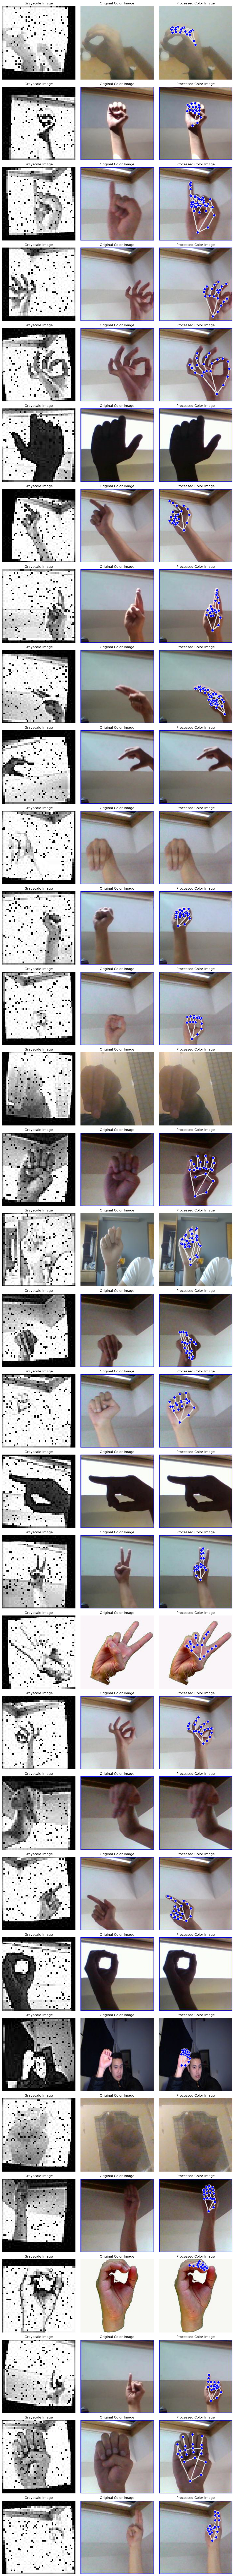

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import mediapipe as mp

mp_hands = mp.solutions.hands.Hands()

def process_with_mediapipe_full(color_images):
    processed_images = []
    for color_image in color_images:
        color_image_np = color_image.permute(1, 2, 0).numpy()
        color_image_np = (color_image_np * 255).astype(np.uint8)  # Convert to uint8
        color_image_np = np.ascontiguousarray(color_image_np)  # Ensure contiguous array
        results = mp_hands.process(color_image_np)
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                mp.solutions.drawing_utils.draw_landmarks(
                    color_image_np, hand_landmarks, mp.solutions.hands.HAND_CONNECTIONS)
        color_image_np = color_image_np.astype(np.float32) / 255.0  # Convert back to float32
        processed_images.append(torch.tensor(color_image_np).permute(2, 0, 1))
    return torch.stack(processed_images)

def visualize_batch(grayscale_images, color_images, processed_color_images):
    batch_size = grayscale_images.size(0)

    fig, axes = plt.subplots(batch_size, 3, figsize=(12, batch_size * 4))
    for i in range(batch_size):
        # Grayscale image
        axes[i, 0].imshow(grayscale_images[i].permute(1, 2, 0).cpu().numpy(), cmap='gray')
        axes[i, 0].set_title('Grayscale Image')
        axes[i, 0].axis('off')

        # Original color image
        axes[i, 1].imshow(color_images[i].permute(1, 2, 0).cpu().numpy())
        axes[i, 1].set_title('Original Color Image')
        axes[i, 1].axis('off')

        # Processed color image with landmarks
        axes[i, 2].imshow(processed_color_images[i].permute(1, 2, 0).cpu().numpy())
        axes[i, 2].set_title('Processed Color Image')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Fetch a batch
data_iter = iter(train_loader)
grayscale_images, color_images, labels = next(data_iter)

# Process w mediapipe
processed_color_images = process_with_mediapipe_full(color_images)

# Visualize the batch
visualize_batch(grayscale_images, color_images, processed_color_images)


In [17]:
mp_hands = mp.solutions.hands.Hands(static_image_mode=True, max_num_hands=1)

model.eval()
test_loss = 0.0
test_correct_predictions = 0
test_total_predictions = 0
all_test_labels = []
all_test_predictions = []
test_progress_bar = tqdm(test_loader, desc='Testing')

with torch.no_grad():
    for data in test_progress_bar:
        grayscale_images, color_images, labels = data

        grayscale_images = grayscale_images.to(device)
        color_images = color_images.to(device)
        labels = labels.to(device)

        landmarks = process_with_mediapipe(color_images)

        outputs = model(grayscale_images, landmarks)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        test_correct_predictions += (predicted == labels).sum().item()
        test_total_predictions += labels.size(0)
        all_test_labels.extend(labels.cpu().numpy())
        all_test_predictions.extend(predicted.cpu().numpy())

        test_progress_bar.set_postfix({
            'test_loss': test_loss / (test_progress_bar.n + 1),
            'test_accuracy': test_correct_predictions / test_total_predictions
        })
epoch_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * test_correct_predictions / test_total_predictions
print(f'Test loss: {epoch_test_loss:.3f}, Test accuracy: {test_accuracy:.3f}')

print('Finished Training and Testing')


I0000 00:00:1717607734.518097 4036956 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 83.1), renderer: Apple M2 Pro
Testing:   0%|                                          | 0/897 [00:00<?, ?it/s]W0000 00:00:1717607734.534924 5298148 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1717607734.542826 5298148 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Testing: 100%|█| 897/897 [11:31<00:00,  1.30it/s, test_loss=0.113, test_accuracy

Test loss: 0.113, Test accuracy: 96.423
Finished Training and Testing


In [20]:
# Initialize MediaPipe
mp_hands = mp.solutions.hands.Hands(static_image_mode=True, max_num_hands=1)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Training loop with accuracy calculation
num_epochs = 10
for epoch in range(num_epochs):

    # Validation step
    model.eval()
    val_loss = 0.0
    val_correct_predictions = 0
    val_total_predictions = 0
    all_labels = []
    all_predictions = []
    val_progress_bar = tqdm(val_loader, desc=f'Epoch {epoch + 1}/{num_epochs} Validation')

    with torch.no_grad():
        for data in val_progress_bar:
            grayscale_images, color_images, labels = data

            # Move data to the device
            grayscale_images = grayscale_images.to(device)
            color_images = color_images.to(device)
            labels = labels.to(device)

            # Process color images to extract landmarks
            landmarks = process_with_mediapipe(color_images)

            outputs = model(grayscale_images, landmarks)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_correct_predictions += (predicted == labels).sum().item()
            val_total_predictions += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

            val_progress_bar.set_postfix({
                'val_loss': val_loss / (val_progress_bar.n + 1),
                'val_accuracy': val_correct_predictions / val_total_predictions
            })

    print(f'Epoch {epoch + 1}, Validation loss: {val_loss / len(val_loader):.3f}, Validation accuracy: {val_correct_predictions / val_total_predictions:.3f}')

print('Finished Validating')



I0000 00:00:1717625850.389827 4036956 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 83.1), renderer: Apple M2 Pro
Epoch 1/10 Validation:   0%|                            | 0/897 [00:00<?, ?it/s]W0000 00:00:1717625850.400151 5464996 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1717625850.407765 5464996 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Epoch 1/10 Validation: 100%|█| 897/897 [11:33<00:00,  1.29it/s, val_loss=0.112, 


Epoch 1, Validation loss: 0.112, Validation accuracy: 0.966


Epoch 2/10 Validation: 100%|█| 897/897 [11:32<00:00,  1.29it/s, val_loss=0.112, 


Epoch 2, Validation loss: 0.112, Validation accuracy: 0.966


Epoch 3/10 Validation: 100%|█| 897/897 [11:30<00:00,  1.30it/s, val_loss=0.112, 


Epoch 3, Validation loss: 0.112, Validation accuracy: 0.966


Epoch 4/10 Validation: 100%|█| 897/897 [11:30<00:00,  1.30it/s, val_loss=0.112, 


Epoch 4, Validation loss: 0.112, Validation accuracy: 0.966


Epoch 5/10 Validation: 100%|█| 897/897 [11:31<00:00,  1.30it/s, val_loss=0.112, 


Epoch 5, Validation loss: 0.112, Validation accuracy: 0.966


Epoch 6/10 Validation: 100%|█| 897/897 [11:32<00:00,  1.30it/s, val_loss=0.112, 


Epoch 6, Validation loss: 0.112, Validation accuracy: 0.966


Epoch 7/10 Validation: 100%|█| 897/897 [11:50<00:00,  1.26it/s, val_loss=0.112, 


Epoch 7, Validation loss: 0.112, Validation accuracy: 0.966


Epoch 8/10 Validation: 100%|█| 897/897 [11:58<00:00,  1.25it/s, val_loss=0.112, 


Epoch 8, Validation loss: 0.112, Validation accuracy: 0.966


Epoch 9/10 Validation: 100%|█| 897/897 [11:54<00:00,  1.25it/s, val_loss=0.112, 


Epoch 9, Validation loss: 0.112, Validation accuracy: 0.966


Epoch 10/10 Validation: 100%|█| 897/897 [11:53<00:00,  1.26it/s, val_loss=0.112,

Epoch 10, Validation loss: 0.112, Validation accuracy: 0.966
Finished Validating


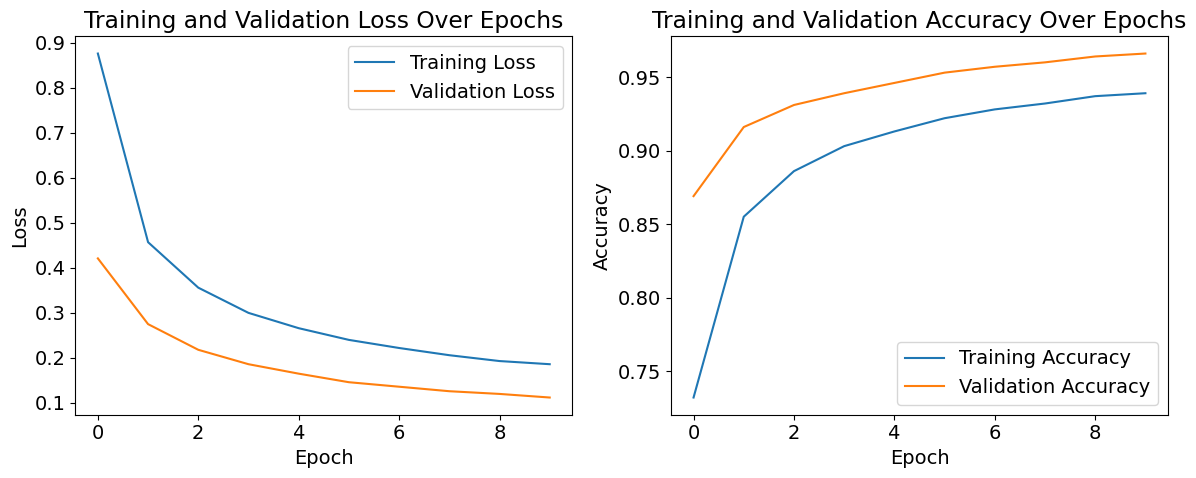

In [24]:
import matplotlib.pyplot as plt

train_losses = [0.876, 0.457, 0.356, 0.300, 0.266, 0.240, 0.222, 0.206, 0.193, 0.186]
val_losses = [0.421, 0.275, 0.218, 0.186, 0.165, 0.146, 0.136, 0.126, 0.120, 0.112]

train_accuracies = [0.732, 0.855, 0.886, 0.903, 0.913, 0.922, 0.928, 0.932, 0.937, 0.939]
val_accuracies = [0.869, 0.916, 0.931, 0.939, 0.946, 0.953, 0.957, 0.960, 0.964, 0.966]

# Set the default font size
plt.rcParams.update({'font.size': 14})

# Plot training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

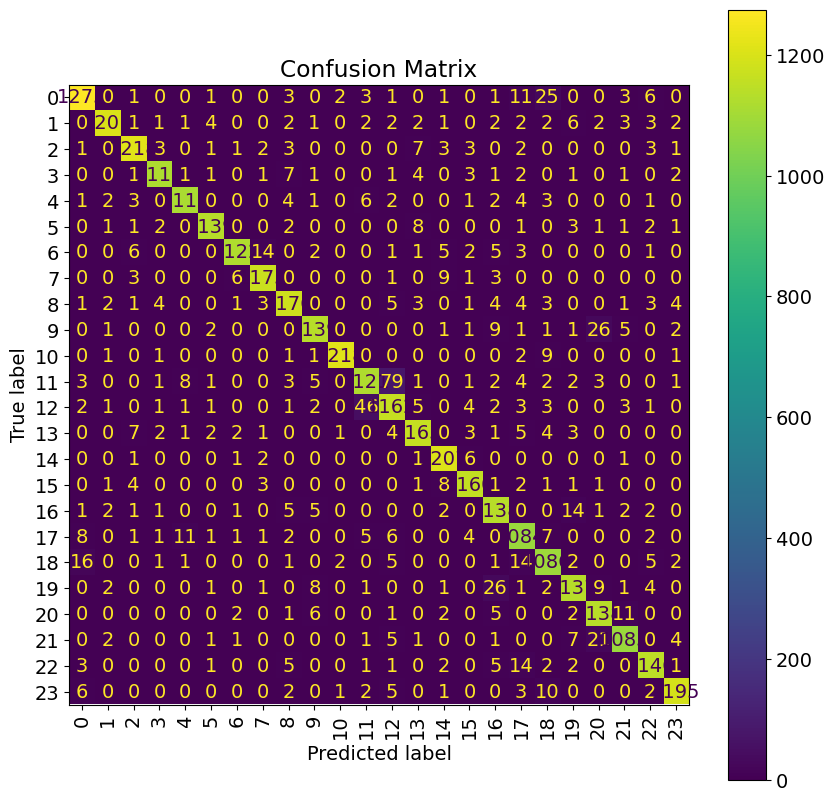

In [27]:
# Generate confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

num_classes = 24
cm = confusion_matrix(all_labels, all_predictions)
cmd = ConfusionMatrixDisplay(cm, display_labels=[i for i in range(num_classes)])
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the size
cmd.plot(ax=ax, xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

In [28]:

mp_hands = mp.solutions.hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence = 0.5)

# Create batch of landmark processed images - full image annotation
def process_with_mediapipe_full(color_images):
    processed_images = []
    count_coord = 0
    for color_image in color_images:
        color_image_np = color_image.permute(1, 2, 0).numpy()
        color_image_np = (color_image_np * 255).astype(np.uint8)  # Convert to uint8
        color_image_np = np.ascontiguousarray(color_image_np)  # Ensure contiguous array
        results = mp_hands.process(color_image_np)
        if results.multi_hand_landmarks:
            count_coord += 1
            for hand_landmarks in results.multi_hand_landmarks:
                mp.solutions.drawing_utils.draw_landmarks(
                    color_image_np, hand_landmarks, mp.solutions.hands.HAND_CONNECTIONS)
        color_image_np = color_image_np.astype(np.float32) / 255.0  # Convert back to float32
        processed_images.append(torch.tensor(color_image_np).permute(2, 0, 1))
    return torch.stack(processed_images), count_coord


total_images = 0
total_images_with_coordinates = 0

for grayscale_images, color_images, labels in train_loader:
    # Process color images with MediaPipe
    processed_color_images, count_coord = process_with_mediapipe_full(color_images)

    # Accumulate counts
    total_images += len(color_images)
    total_images_with_coordinates += count_coord

    # Visualize the current batch (optional)
    #visualize_batch(grayscale_images, color_images, processed_color_images)

# Calculate and print the overall percentage
overall_percentage = total_images_with_coordinates / total_images * 100
print(f"Overall percentage of images with coordinates: {overall_percentage:.2f}%")

I0000 00:00:1717633758.699768 4036956 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 83.1), renderer: Apple M2 Pro
W0000 00:00:1717633758.718600 5589253 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1717633758.725485 5589253 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/Users/malaviravindran/miniconda3/envs/cs224n/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Overall percentage of images with coordinates: 66.52%


In [29]:
# Calculate and print the overall percentage
overall_percentage = total_images_with_coordinates / total_images * 100
print(f"Overall percentage of images with coordinates: {overall_percentage:.2f}%")

Overall percentage of images with coordinates: 66.52%
